In [ ]:
!pip install exetera

In [3]:
"""
This example shows the filtering functions of Exetera.
Presume we have the test dataset (contains the result of covid tests), and want to examinate the number of positive/negative tests trunked by each week.
We can use the date as a filter, to filter the test samples that falls in the specific range of dates. 
"""
%matplotlib inline
from datetime import datetime, timedelta
import numpy as np
import h5py
import matplotlib.pyplot as plt

from exetera.core.session import Session
from exetera.core import dataframe

# Here we specify the start and end date to examinate
# start_date = # datetime(year, month, date), inclusive
# end_date = # datetime(year, month, date), exclusive
# filename = # file name for source dataset

# The date is then trunked by week (7 days)
dates = [end_date]
cur_date = end_date - timedelta(days=7)
while cur_date >= start_date:
    dates.append(cur_date)
    cur_date -= timedelta(days=7)
dates.reverse()

In [4]:
from collections import defaultdict

# Open Exetera session
with Session() as s:
    # Open the dataset
    src = s.open_dataset(filename, 'r', 'src')
    # Select the 'tests' dataframe
    t_src = src['tests']
    # Select the data from 'date_taken_specific' and 'result' column
    test_created_at_ = t_src['date_taken_specific'].data[:]
    test_results_ = t_src['result'].data[:]
    # Show the type of unique tests, followed by the number of each type
    print(np.unique(test_results_, return_counts=True))
    # Create two numpy array to store the results
    partitions = len(dates)-1
    negative_tests_by_range = np.zeros(partitions, dtype=np.int32)
    positive_tests_by_range = np.zeros(partitions, dtype=np.int32)

    for d in range(partitions):
        start_timestamp = dates[d].timestamp()
        end_timestamp = dates[d+1].timestamp()
        # Create an identifier array of True/False values, to mark if the test is taken during the dates we want
        in_current_month = (start_timestamp <= test_created_at_) & (test_created_at_ < end_timestamp)
        # print(dates[d], in_current_month.sum())
        
        # Use the identifier to filter data we want (by leave only the data indexed True values)
        monthly_tests = s.apply_filter(in_current_month, test_results_)
        
        # Show results and store into the numpy array
        result_counts = np.unique(monthly_tests, return_counts=True)
        print(result_counts)
        result_counts = defaultdict(int, zip(result_counts[0], result_counts[1]))
        print(result_counts)
        negative_tests_by_range[d] = result_counts[3]
        positive_tests_by_range[d] = result_counts[4]


(array([1, 2, 3, 4], dtype=int8), array([ 161129,   45599, 5633561,  214082]))
(array([1, 2, 3, 4], dtype=int8), array([  1510,    431, 196572,   1975]))
defaultdict(<class 'int'>, {1: 1510, 2: 431, 3: 196572, 4: 1975})
(array([1, 2, 3, 4], dtype=int8), array([  1508,    401, 240661,   2049]))
defaultdict(<class 'int'>, {1: 1508, 2: 401, 3: 240661, 4: 2049})
(array([1, 2, 3, 4], dtype=int8), array([  1643,    470, 254126,   1797]))
defaultdict(<class 'int'>, {1: 1643, 2: 470, 3: 254126, 4: 1797})
(array([1, 2, 3, 4], dtype=int8), array([  1748,    425, 243342,   2044]))
defaultdict(<class 'int'>, {1: 1748, 2: 425, 3: 243342, 4: 2044})


<ipython-input-5-5b3f349250f9>:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


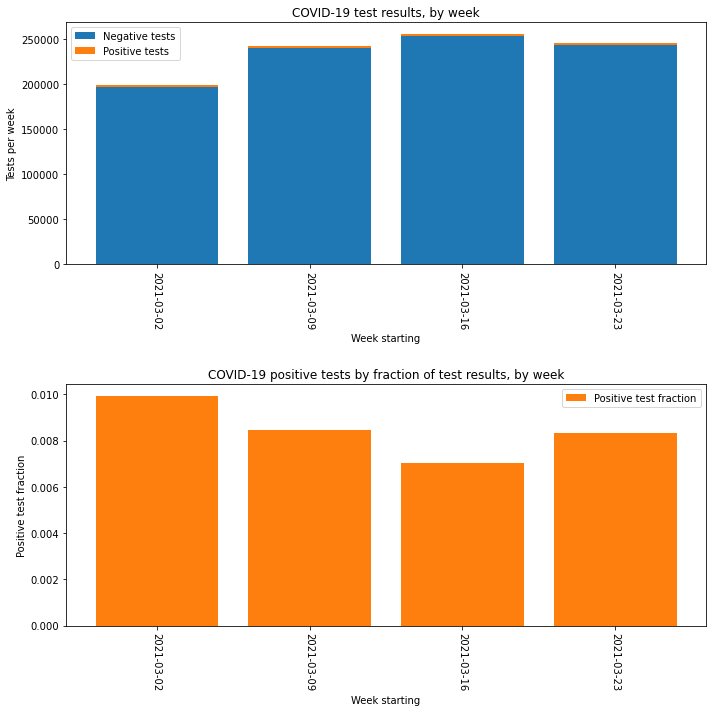

In [5]:
# Plot the data using matplotlib
width = 1
widths = [width * d for d in range(partitions)]

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

negtests = ax[0].bar(widths, negative_tests_by_range)
postests = ax[0].bar(widths, positive_tests_by_range, bottom=negative_tests_by_range)

ax[0].set_title("COVID-19 test results, by week")
ax[0].set_xticks(np.arange(partitions))
ax[0].set_xticklabels([datetime.strftime(d, '%Y-%m-%d') for d in dates[:-1]], rotation=270)
ax[0].legend((negtests, postests), ("Negative tests", "Positive tests"))
ax[0].set_xlabel("Week starting")
ax[0].set_ylabel("Tests per week")

pos_fraction = positive_tests_by_range / (positive_tests_by_range + negative_tests_by_range)
pfbar = ax[1].bar(widths, pos_fraction, color="#ff7f0e")

ax[1].set_title("COVID-19 positive tests by fraction of test results, by week")
ax[1].set_xticks(np.arange(partitions))
ax[1].set_xticklabels([datetime.strftime(d, '%Y-%m-%d') for d in dates[:-1]], rotation=270)
ax[1].legend((pfbar,), ("Positive test fraction",))
ax[1].set_xlabel("Week starting")
ax[1].set_ylabel("Positive test fraction")

fig.tight_layout(h_pad=2.5)
fig.show()
